# Trump Twitter Sentiment Classification and Analysis

<div class="alert alert-block alert-danger">
<b>Note:</b> Model metrics got changed when I reran the whole notebook. I tried altering the summary/findings but there still may be mistakes.
</div>

# Data Understanding

#### Data Dictionary

- **id**: identification
- **link**: link to source of content
- **content**: tweet contents
- **date**: time tweet was published
- **retweets**: number of times tweet was retweeted 
- **favorites**: number of user who favorited tweet
- **mentions**: accounts tagged in post
- **hashtags**: hashtags used in post
- **geo**: no records / not sure
- **Sentiment**: Positive or Negative

#### Objective

The objective of this notebook is to build supervised classification models based on the data in attempts to accurately classifify the sentiment.

#### Pre Requisites

In [1]:
# Basic Libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Other Libraries
import wordcloud

In [3]:
# Data Source
FILE_NAME = r"..\DataSets\trumpTweets.csv"

sns.set_style("whitegrid") # for nicer graphs

In [4]:
""" Some user defined functions. """

# needs wordcloud, matplotlib
def show_wordcloud(data: pd.DataFrame, text_column: str, title: str):
    text = ' '.join(data[text_column].tolist())
    fig_wordcloud = wordcloud.WordCloud(stopwords=set(wordcloud.STOPWORDS),background_color='white', # Setting the different parameter of stopwords
    colormap='viridis', width=800, height=600).generate(text)

    plt.figure(figsize=(14,11), frameon=True)
    plt.imshow(fig_wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=30)
    plt.show()


# function to plot a boxplot and a histogram along the same scale.
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
     
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)                                            # Nu of zero in each column
        mis_val = df.isnull().sum()                                                                #Missing value in each column
        mis_val_percent = 100 * df.isnull().sum() / len(df)                                        #Missing value percent accross column
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)                         #Concatenation of above aoutput
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})               #Renaming of each coumn
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']  #column having total of zero value and missing values
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df) # Column having percentage of totalof zero and missing value
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(                                                     #Selecting and sorting those column which have at not a zero value in % of Total Values column
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

#### Data Overview

In [5]:
# Read & Sample Data
data = pd.read_csv(FILE_NAME, index_col=0)
print(f"[{FILE_NAME}] Rows: {data.shape[0]}, Columns: {data.shape[1]}")
data.sample(5)

[..\DataSets\trumpTweets.csv] Rows: 41122, Columns: 10


,id,link,content,date,retweets,favorites,mentions,hashtags,geo,Sentiment
16967,504007556483002370,https://twitter.com/realDonaldTrump/status/504...,"ICYMI, my @ ABC7News Washington Business Repor...",2014-08-25 22:49:00,31,31,@ @ABC7Rebecca,NaN,NaN,positive
20207,557008995844882432,https://twitter.com/realDonaldTrump/status/557...,""" @ SritaColombia: Do you think that # MissUni...",2015-01-19 03:57:47,77,125,@ @,#,NaN,positive
1614,180761387411320833,https://twitter.com/realDonaldTrump/status/180...,# CelebApprentice fans watch today's # trumpvl...,2012-03-16 22:04:07,42,18,NaN,# #,NaN,positive
40204,1192418595323682817,https://twitter.com/realDonaldTrump/status/119...,Bill Barr did not decline my request to talk a...,2019-11-07 13:28:41,23164,85375,NaN,NaN,NaN,positive
28324,709736764613771264,https://twitter.com/realDonaldTrump/status/709...,# VoteTrump # SuperTuesday Florida Illinois Mi...,2016-03-15 14:43:25,5643,13689,NaN,# # #,NaN,positive


41,122 Observations total in data set. Nine possible predictors for the feature, "Sentiment."

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41122 entries, 0 to 41121
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         41122 non-null  int64  
 1   link       41122 non-null  object 
 2   content    41122 non-null  object 
 3   date       41122 non-null  object 
 4   retweets   41122 non-null  int64  
 5   favorites  41122 non-null  int64  
 6   mentions   22467 non-null  object 
 7   hashtags   5810 non-null   object 
 8   geo        0 non-null      float64
 9   Sentiment  41122 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 3.5+ MB


In [7]:
missing_zero_values_table(data)

Your selected dataframe has 10 columns and 41122 Rows.
There are 3 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
geo,0,41122,100.0,41122,100.0,float64
hashtags,0,35312,85.9,35312,85.9,object
mentions,0,18655,45.4,18655,45.4,object


Geo, mentions, and hashtags, should be filtered out. They have many missing values. 

In [8]:
# Unique values in data
data.nunique()

id           41122
link         41122
content      40909
date         40812
retweets     12924
favorites    16301
mentions      2795
hashtags       141
geo              0
Sentiment        2
dtype: int64

Link and id have the same meaning. These too would be a waste of time to analyze as they are unique identifiers.

In [9]:
data.drop(["geo", "hashtags", "mentions", "id", "link"], axis=1, inplace=True)
data.sample(1)

,content,date,retweets,favorites,Sentiment
2870,"Palm Springs, CA has been destroyed--absolutel...",2012-08-16 23:30:24,171,96,negative


**Before Moving On**: 

The columns "geo," "hashtags," "mentions," "id," and "link," were dropped. The reason for this was due to the many missing values or non predictive properties. 

**Conversion(s) Needed**
- content dtype -> string
- Sentiment -> string
- date dtype -> datetime

## Data Prepocessing 

#### Fixing Data Types

In [10]:
# Changeing data types of contents, and Sentiment

data["Sentiment"] = data["Sentiment"].convert_dtypes(str)
data["content"] = data["content"].convert_dtypes(str)

# conversion of date object to datetime
data["date"] = pd.to_datetime(data["date"])

#### Missing Values?

In [11]:
data.isnull().sum()

content      0
date         0
retweets     0
favorites    0
Sentiment    0
dtype: int64

No missing values in columns we are going to possibly use for modeling in dataset.

#### Duplicate Data?

In [12]:
data.duplicated().sum()

0

No duplicate observations in this data set.

#### Inconsistant Data?

In [13]:
data.nunique()

content      40909
date         40812
retweets     12924
favorites    16301
Sentiment        2
dtype: int64

In [14]:
duplicates = data[data.duplicated('content', keep=False)]
duplicates

,content,date,retweets,favorites,Sentiment
1011,"""People who have the ability to work should. B...",2011-12-20 19:57:49,411,53,positive
1038,@ TrumpCollection tops @ TravlandLeisure 500 B...,2011-12-27 14:56:27,4,2,positive
1049,@ TrumpCollection tops @ TravlandLeisure 500 B...,2011-12-28 15:51:24,5,1,positive
1103,"""People who have the ability to work should. B...",2012-01-06 18:37:38,525,87,positive
1615,Be sure to download my new The Celebrity Appre...,2012-03-17 18:59:55,50,11,positive
...,...,...,...,...,...
40793,PRESIDENTIAL HARASSMENT!,2019-12-19 14:30:50,39169,196534,negative
40930,Read the Transcripts!,2019-12-31 18:34:45,17000,95396,positive
40970,95% Approval Rating in the Republican Party. T...,2020-01-04 15:57:14,43597,338374,positive
40996,PRESIDENTIAL HARASSMENT!,2020-01-09 13:30:27,32092,200966,negative


It looks like some of the tweets are copy pastes. I'll keep them for now.

### Outliers?

> See EDA

**To Note**:

Sentiment (the label) has only Positive or Negative. There is a small number of duplicated tweets that were **not** dropped. 

## Exploratory Data Analysis (EDA) 

### Univariate

content

Text(0.5, 0.98, 'Characters in message')

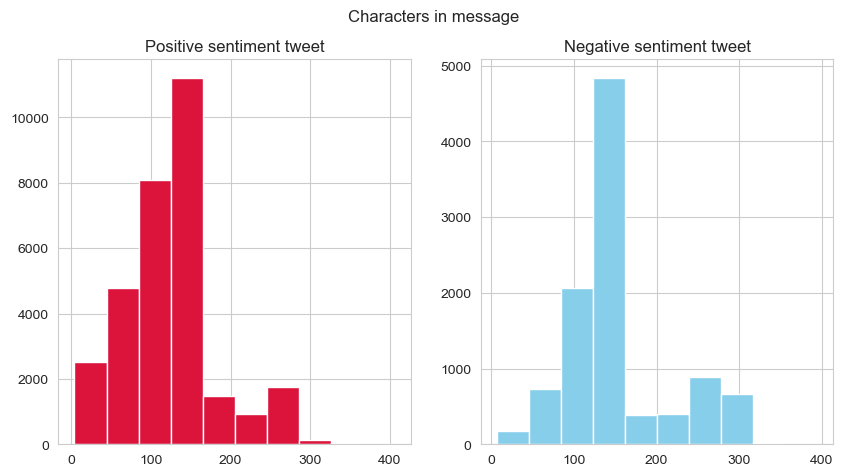

In [15]:
#Number of characters in tweets
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = data[data['Sentiment']=='positive']['content'].str.len()
ax1.hist(tweet_len,color='crimson')
ax1.set_title('Positive sentiment tweet')
tweet_len = data[data['Sentiment']=='negative']['content'].str.len()
ax2.hist(tweet_len,color='skyblue')
ax2.set_title('Negative sentiment tweet')
fig.suptitle('Characters in message')

The negative tweets look to have more characters than the positive

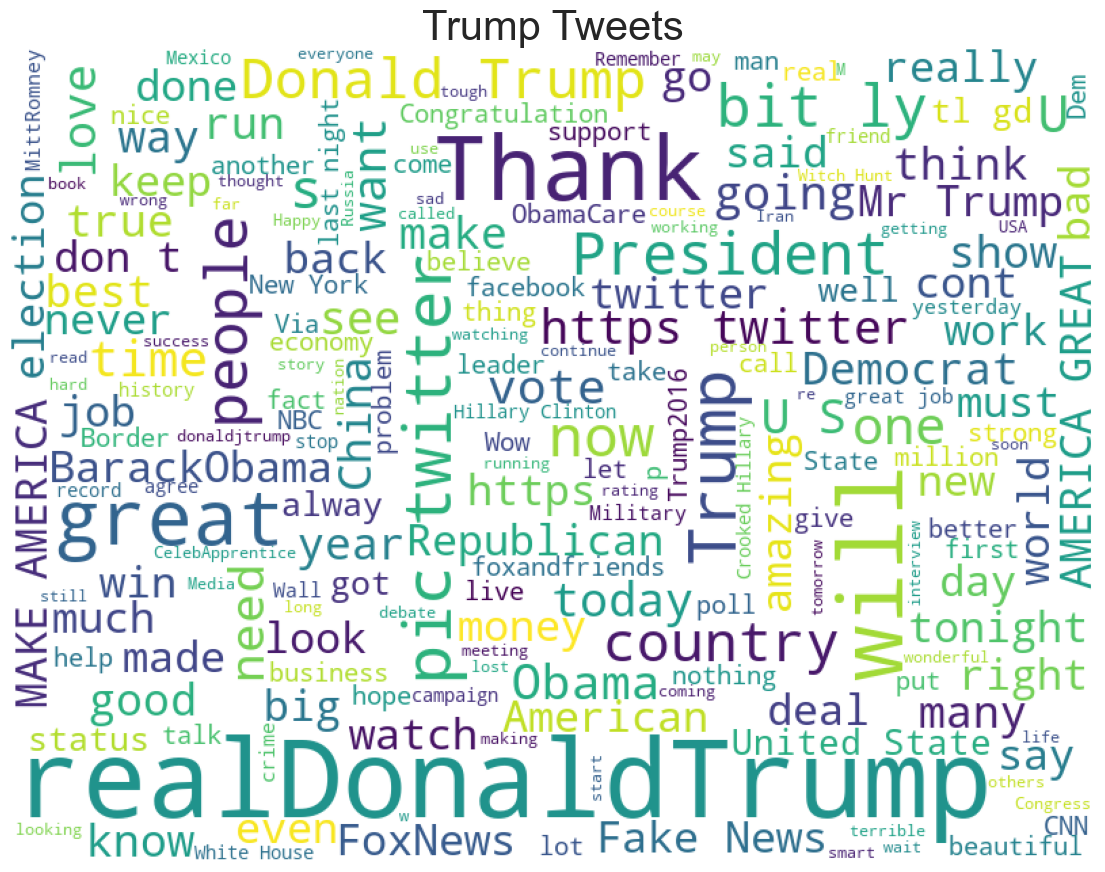

In [16]:
show_wordcloud(data, "content", "Trump Tweets")

realDonaldTrump is the most frequent. Looks like the text needs to be processed further (notice https).

date

In [17]:
start = min(data["date"])
end = max(data["date"])
print(f"{start} to {end}")

2009-05-04 20:54:25 to 2020-01-20 02:57:49


These tweets were collected from May 2009 to January 2020.

retweets

C:\Users\chadp\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


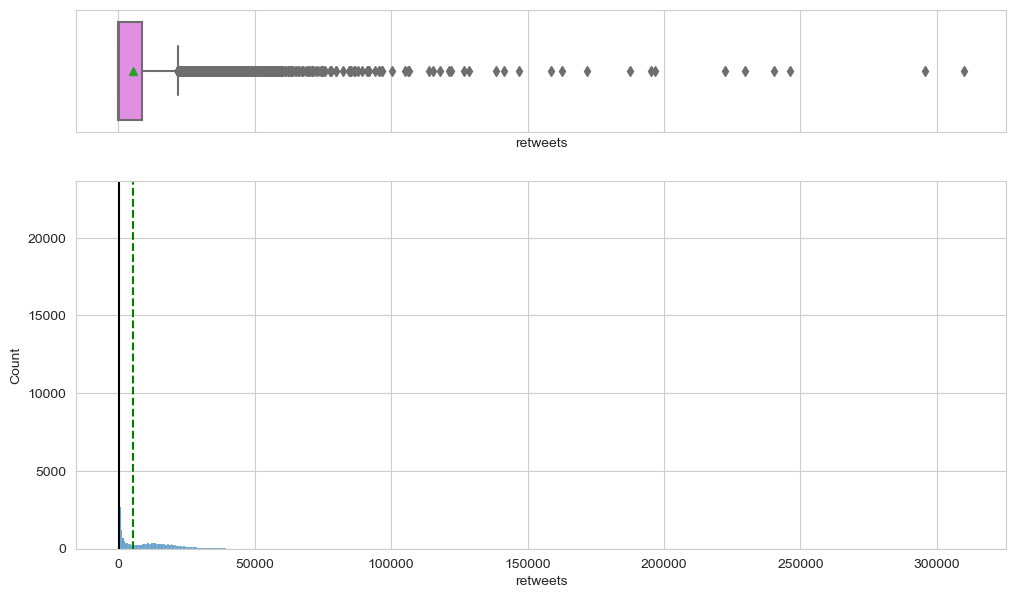

In [18]:
histogram_boxplot(data, "retweets")

Some tweets fared much better than others. Number of retweets per tweet is not normal. Skewed to the right. All outliers past the upper bounds. Perhaps a 3 part bin could be useful if included in the model. Low, Medium, and High. Low < 10k, Medium < 40k, and High >= 40k.

favorite

C:\Users\chadp\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


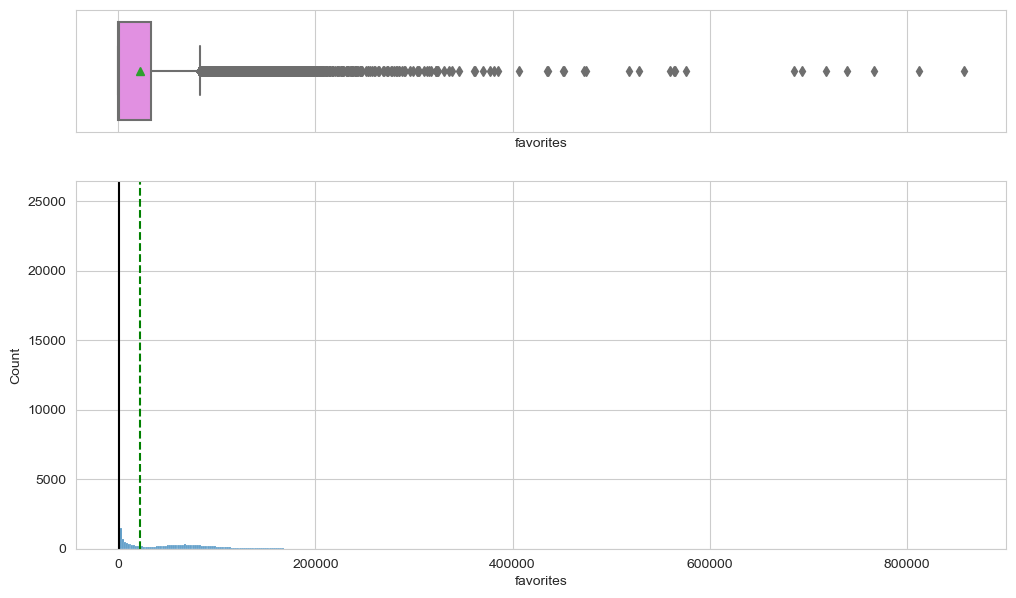

In [19]:
histogram_boxplot(data, "favorites")

Similar to "retweets," number of people who favorited the tweet is skewed to the right. Many outliers past the upper bounds while none below the lower.  

Sentiment

<Axes: xlabel='Sentiment', ylabel='count'>

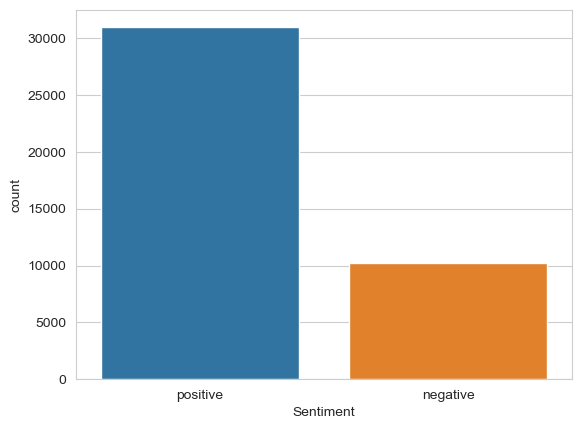

In [20]:
sns.countplot(data, x ="Sentiment")

Many tweets more positive than negative.

### Multivariate

C:\Users\chadp\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


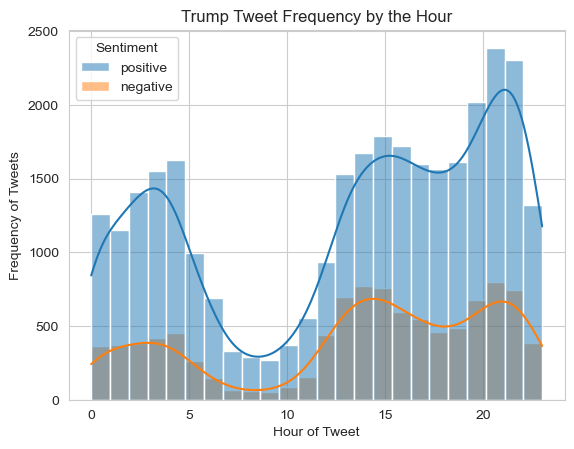

In [21]:
data["hour"] = data["date"].dt.hour
sns.histplot(data, x = "hour", bins=24, kde=True, hue="Sentiment")
plt.title("Trump Tweet Frequency by the Hour")
plt.ylabel('Frequency of Tweets')
plt.xlabel('Hour of Tweet')
data.drop("hour", axis=1, inplace=True)

Mr. Trump seems to like to tweet right after dinner. He tweeted the most a little after 8pm (20:00). Since the ratio of sentiment is in favor of positive, from the graph, the hour of the day seems to have no predictive qualities.

C:\Users\chadp\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


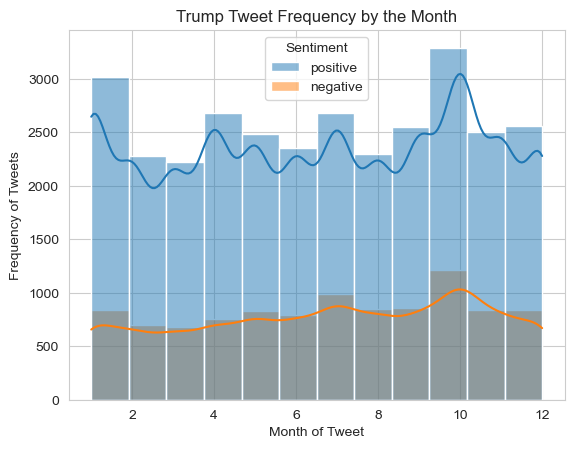

In [22]:
data["month"] = data["date"].dt.month
sns.histplot(data, x = "month", bins=12, kde=True, hue="Sentiment")
plt.title("Trump Tweet Frequency by the Month")
plt.ylabel('Frequency of Tweets')
plt.xlabel('Month of Tweet')
data.drop("month", axis=1, inplace=True)

Mr. Trump has historically tweeted the most around the month of October (10).

C:\Users\chadp\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


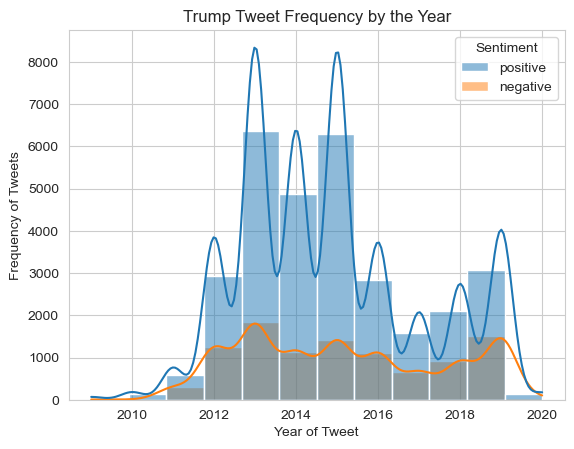

In [23]:
data["year"] = data["date"].dt.year
sns.histplot(data, x = "year", bins=12, kde=True, hue="Sentiment")
plt.title("Trump Tweet Frequency by the Year")
plt.ylabel('Frequency of Tweets')
plt.xlabel('Year of Tweet')
data.drop("year", axis=1, inplace=True)

Surprisingly, most of the tweets are from 2013 to 2015.

### Correlation Analysis

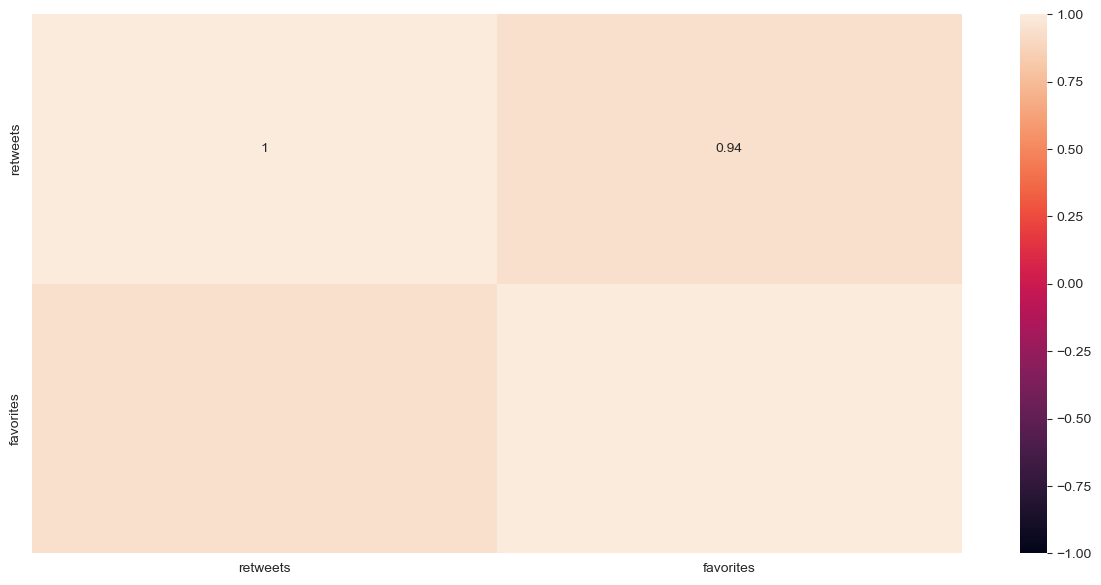

In [24]:
plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(numeric_only=True), annot=True, vmin=-1, vmax=1)
plt.show()

Favorites and retweets are highly correlated (0.94). Favorites or retweets could be dropped based on this information.

### Summary of EDA

- The time series analysis did not uncover any intersting relationships. 
- Either retweets or favorites should be dropped.
- Retweets and favorites have many outliers. Not going to drop, probably bin.
- The column "content" needs to undergo text prepocessing.
- In this data set, there is more positive observations than negative. 

## Feature Engineering 

### Steps Taken
- dropped "favorites"
- Bin of retweets Low: < 10k , Med < 40k, High >= 40k (See EDA for thought)
- date binned to Quaters (Q1, Q2, Q3, Q4)

In [25]:
# dropping favorites
data.drop("favorites", axis=1, inplace=True)

In [26]:
# Bin of retweets #
#     0 = Low
#     1 = Med
#     2 = High
data["retweets"] = data["retweets"].apply(lambda row: 0 if row < 10_000 else 1 if row < 40_000 else 2)

In [27]:
# date to month to bin

# KEY 
Q1 = list(range(1, 4)) # 0 
Q2 = list(range(4, 7)) # 1
Q3 = list(range(7, 10))# 2
# Q4                   # 3

data["date"] = data["date"].apply(lambda row: 0 if row.month in Q1
                  else 1 if row.month in Q2
                  else 2 if row.month in Q3
                  else 3)

In [28]:
# For better understanding down the line
data = data.rename(columns={"date":"quarter"})

## Text Preprocessing

<div class="alert alert-block alert-info">
<b>Note:</b> For future use, make sure to set the proper text column to text.
</div>

### Steps Taken
    
- replace contractions Ex: don't -> do not
- remove links, html tags, punctuation
- remove numbers, convert to lowercase
- tokenize text
- lemmatize, remove stopwords

In [29]:
# IMPORTANT: assert proper column
text = data["content"]

In [30]:
""" Methods for replacing contractions in text. """

import contractions

def replace_contractions(text):
    return contractions.fix(text)

In [31]:
""" Methods for html, number, punctuation, and link removal. """

import re

def remove_html(text):
    return re.sub(r'<.*?>', '', text) 
    
def remove_numbers(text):
    return re.sub(r'\d+', '', text)  

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

def remove_links(text):
    return re.sub(r'http\S+|www.\S+', '', text)

def pretty_text(ugly_text: str) -> str:
    ugly_text = f"{ugly_text}"
    cleaned_text = remove_html(ugly_text)
    cleaned_text = remove_numbers(cleaned_text)
    cleaned_text = remove_punctuation(cleaned_text)
    cleaned_text = remove_links(cleaned_text)
    return cleaned_text

In [32]:
""" Pre Tokenization of Text. """
# contraction replacement first, then "prettify"
text = text.apply(lambda row: replace_contractions(row))
text = text.apply(lambda row: pretty_text(row))

# conversion to lowercase
text = text.apply(lambda row: row.lower())

In [33]:
""" Methods for tokenization, lemmatization, and stopword removal. """

import nltk
from nltk.corpus import stopwords                       
from nltk.stem.wordnet import WordNetLemmatizer  

nltk.download('stopwords')                              
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer() # for method, "lematize_list"

customList = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

stopwords = stopwords.words('english') # for method, "remove_stopwords"
stopwords = list(set(stopwords) - set(customList)) # keeping customList

def lemmatize_token(wordList):
    lemma = list()
    for word in wordList:
        lemma.append(lemmatizer.lemmatize(word, pos="v")) # verbs only
    return lemma

def text_to_token(text: str):
    return nltk.word_tokenize(text)

def remove_stopwords(wordList):
    """Remove stop words from list of tokenized words"""
    new_words = list()
    for word in wordList:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def tokeLemmaStop(text):
    text = text_to_token(text)
    text = lemmatize_token(text)
    text = remove_stopwords(text)
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chadp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chadp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chadp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\chadp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [34]:
""" Post Tokenization. """

text = text.apply(lambda row: tokeLemmaStop(row)) # lemmatization and stopword removal too

In [35]:
# IMPORTANT: assert proper column
data["content"] = text

In [36]:
negative = data[data["Sentiment"] == "negative"]
negative_text = ' '.join(negative['content'].astype(str))

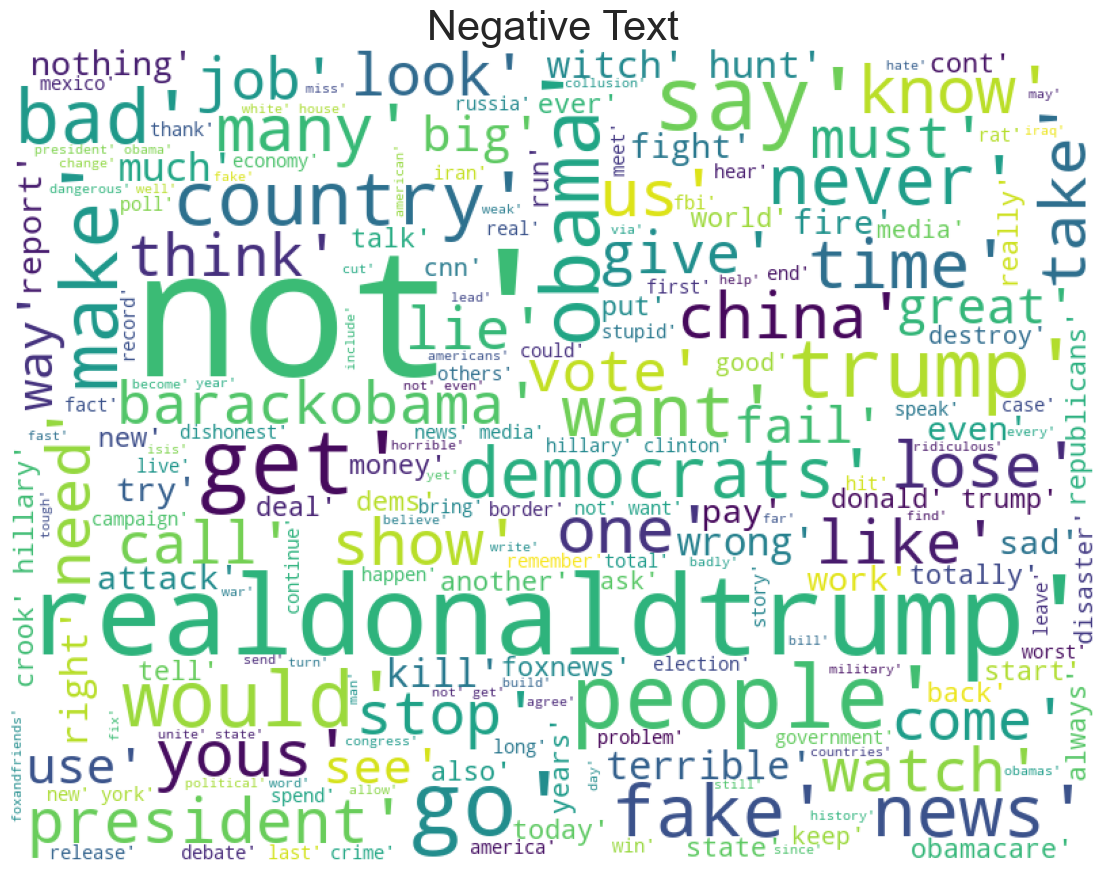

In [37]:
""" Negative Wordcloud """

# show_wordcloud method didn't work, had to do manual
negative = data[data["Sentiment"] == "negative"]
negative_text = ' '.join(negative['content'].astype(str))

fig_wordcloud = wordcloud.WordCloud(stopwords=set(wordcloud.STOPWORDS),background_color='white', # Setting the different parameter of stopwords
    colormap='viridis', width=800, height=600).generate(negative_text)

plt.figure(figsize=(14,11), frameon=True)
plt.imshow(fig_wordcloud)
plt.axis('off')
plt.title("Negative Text", fontsize=30)
plt.show()


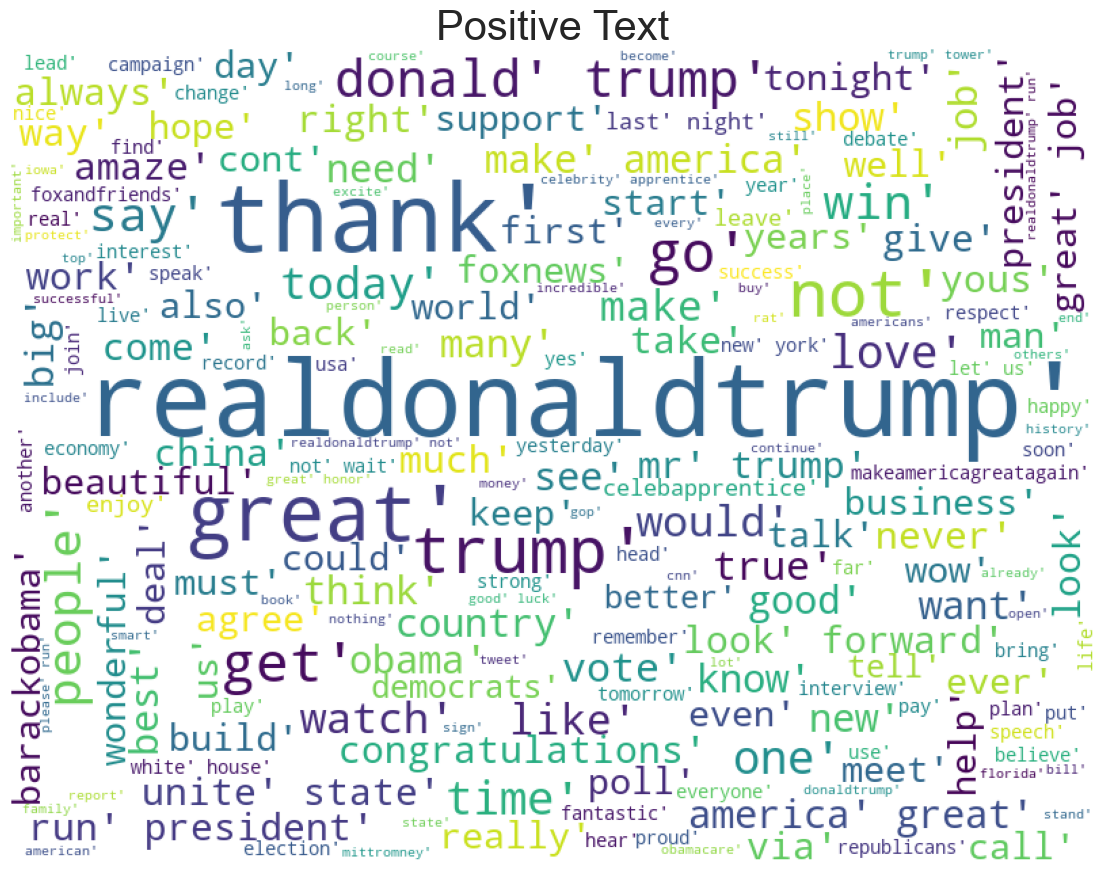

In [38]:
""" Positive Wordcloud """

# show_wordcloud method didn't work, had to do manual
negative = data[data["Sentiment"] == "positive"]
positive_text = ' '.join(negative['content'].astype(str))

fig_wordcloud = wordcloud.WordCloud(stopwords=set(wordcloud.STOPWORDS),background_color='white', # Setting the different parameter of stopwords
    colormap='viridis', width=800, height=600).generate(positive_text)

plt.figure(figsize=(14,11), frameon=True)
plt.imshow(fig_wordcloud)
plt.axis('off')
plt.title("Positive Text", fontsize=30)
plt.show()

realdonaldtrump is popular in both negative and positive sentiment. Could this affect the model? Positive words look mostly positive and same is true with negative.

# Encoding

### Steps Taken 
- Vectorization of text data (Bag of Words Method)
- Conversion of Sentiment into 0 or 1
- Date and Retweets done in feature engineering

<div class="alert alert-block alert-info">
<b>Note:</b> To reduce time in testing, change the NUM_FEATURES in the vectorization of content.
</div>

In [39]:
# conversion to string needed 
data["content"] = data["content"].astype(pd.StringDtype())

In [40]:
# for testing purposes
dataOne = data.copy()

In [41]:
""" Vectorization of Content. """

NUM_FEATURES: int = 200

from sklearn.feature_extraction.text import CountVectorizer
 
bow_vec = CountVectorizer(max_features=NUM_FEATURES)

data_features = bow_vec.fit_transform(dataOne['content'])      

In [42]:
""" Inputs for model(s). """

# dependent
target = [1 if num == "positive" else 0 for num in dataOne["Sentiment"]]

# independent(s)
#     content
data_features = data_features.toarray() #"content"
#     retweets
retweets = dataOne["retweets"]
#     quarter
quarter = dataOne["quarter"]

In [43]:
# Combo into independents
X = np.column_stack((data_features, retweets, quarter))

# Modeling

<div class="alert alert-block alert-danger">
<b>Note:</b> Model metrics got changed when I reran the whole notebook. I tried altering the summary/findings but there still may be mistakes.
</div>

### General Steps Taken

- choose variables and text vectorization method 
- split data into train, test (possibly validation)
- Initial Random Forest Model
- K-Fold Cross Validation
- Model with best number of n_estimators
- Confusion matrix of True positives vs false and False positives vs true

## Model 1: Random Forest, Bag Of Words + "content," "retweets"

In [44]:
""" Testing and Train split. """

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, target, # inputs
                                                    test_size=0.2, # train size will compliment 
                                                    random_state=7
                                                   )

In [45]:
""" Random Forest Setup & Cross Validation """

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
 
rf_model = RandomForestClassifier(n_estimators=10, n_jobs=4) # calling model
rf_model.fit(X_train, y_train) # fit model on data

rf_crossVal = (np.mean(cross_val_score(rf_model, X, target, cv=10))) # cross validation metric

print(f"Accuracy: {rf_model.score(X_test, y_test):.5}") # train vs test
print(f"Cross Validation Score [10 folds]: {rf_crossVal:.5}")

Accuracy: 0.77763
Cross Validation Score [10 folds]: 0.75244


The Random Forest model was correct in sentiment classification 78.2% of the time on the test data set. Dduring the cross validation, the data set was split into 10 equal parts. Each part was used as the test once while the other 9 parts or folds were used the training. The score above is the average accuracy of each go around.

In [46]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = list(range(1,25))

In [47]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

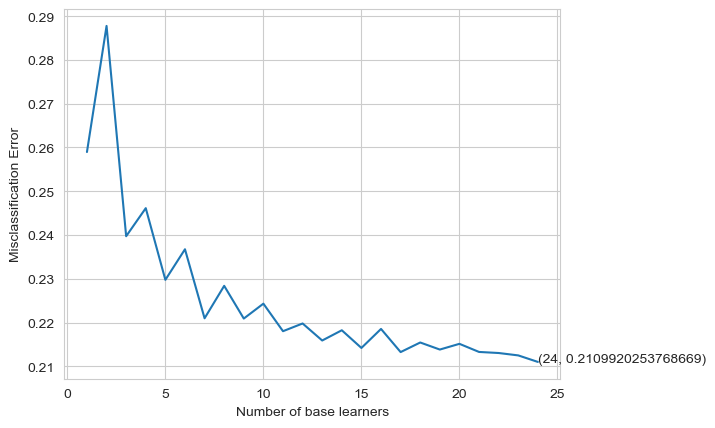

In [48]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [49]:
# Training the best model and calculating error on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
print(f"Optimal Learners: {optimal_learners}")
print(f"Accuracy: {clf.score(X_test, y_test)}")

Optimal Learners: 24
Accuracy: 0.7928267477203648


The accuracy went up almost 2% when the optimized number of "learners" was 23.

In [50]:
result =  clf.predict(X_test)                  #saving the prediction on test data as a result

          Negative  Positive
Negative      1005      1005
Positive       699      5516
0.7928267477203648


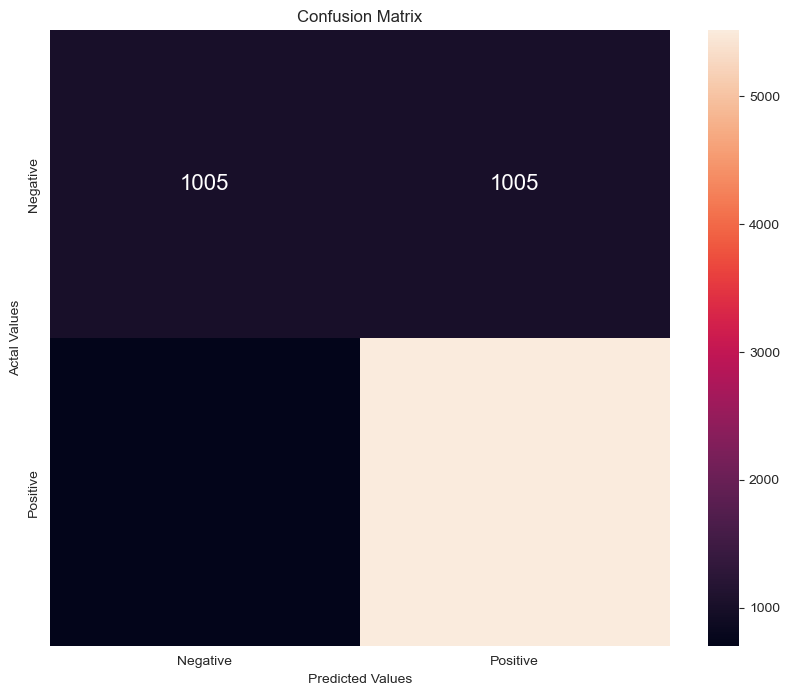

In [51]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

conf_mat = pd.DataFrame(conf_mat,
                     index = ['Negative', 'Positive'],
                     columns = ['Negative', 'Positive'])

print(conf_mat)

print(metrics.f1_score(y_test, result,average='micro'))

#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True,fmt='g', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

Model 1 has a f1 score of 79.3%. The model is better at identifying positive sentiment than negative. 

## Model 2: Random Forest, TfidVectorizer

<div class="alert alert-block alert-info">
<b>Note:</b> In this model, I opted to use the text as the only features thus excluding: "quarter," & "retweets"
</div>

In [52]:
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=200)
data_features = vectorizer.fit_transform(data["content"])

data_features = data_features.toarray()

data_features.shape

(41122, 200)

In [53]:
# Split data into training and testing set.

X_train, X_test, y_train, y_test = train_test_split(data_features, target, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [54]:
rf_model = RandomForestClassifier(n_estimators=10, n_jobs=4)

rf_model.fit(X_train, y_train)

rf_crossVal = (np.mean(cross_val_score(rf_model, X, target, cv=10))) # cross validation metric

print(f"Accuracy: {rf_model.score(X_test, y_test):.5}") # train vs test
print(f"Cross Validation Score [10 folds]: {rf_crossVal:.5}")

Accuracy: 0.78674
Cross Validation Score [10 folds]: 0.75332


Accuracy better than model 1's original start. Cross validation much lower than original accuracy. Train data for accuracy was overfit so model 1 actually had a better start.

In [55]:
# K - Fold Cross Validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

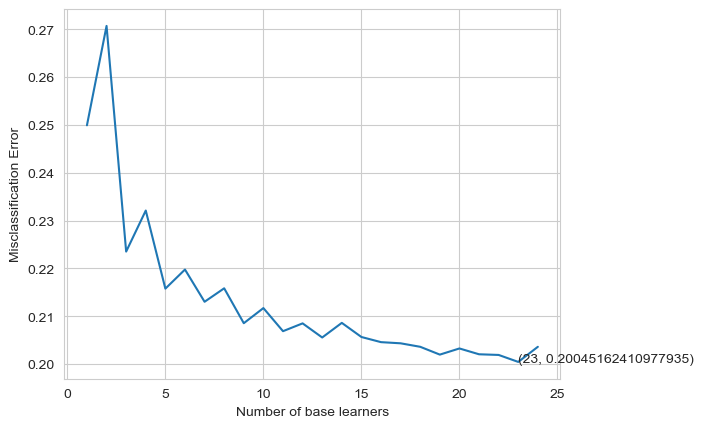

In [56]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                              #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                             #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                                        #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [57]:
# Training the best model and calculating error on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
print(f"Optimal Learners: {optimal_learners}")
print(f"Accuracy: {clf.score(X_test, y_test)}")

Optimal Learners: 23
Accuracy: 0.7947637188943828


The accuracy improvement was negligible at the optimized number of learners (21). 

In [58]:
# saving result for confussion matrix
result = clf.predict(X_test)

          Negative  Positive
Negative      1314      1777
Positive       755      8491
0.7947637188943828


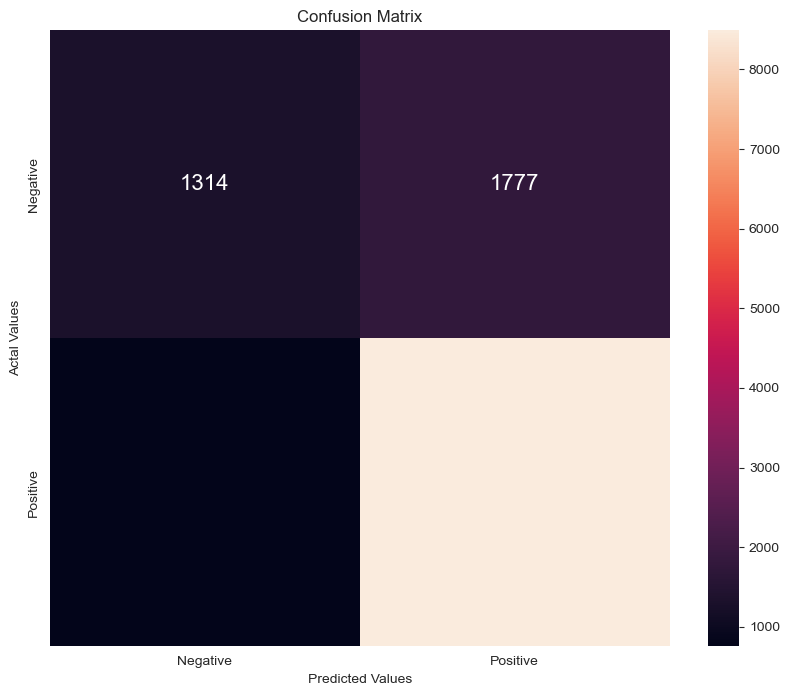

In [59]:
conf_mat = confusion_matrix(y_test, result)

conf_mat = pd.DataFrame(conf_mat,
                     index = ['Negative', 'Positive'],
                     columns = ['Negative', 'Positive'])

print(conf_mat)

print(metrics.f1_score(y_test, result,average='micro'))

#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True,fmt='g', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

The model had an f1 score of 79.3%. The model was better at predicting true positives (8478/1781) when compared to true negatives (1310/768). When compared to model 1, there is no drastic improvements. 

#### Wordcloud top 40 "content"

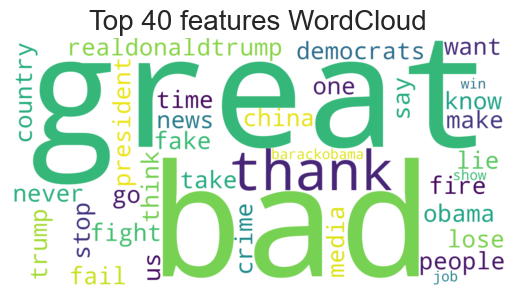

In [60]:
""" Wordcloud of top 40 text features. """

all_features = vectorizer.get_feature_names_out()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=' '

myWc2 = wordcloud.WordCloud(background_color="white",colormap='viridis',width=2000,
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(myWc2, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

Great, bad, and thank look to be the most important features in the machine learning model. This isn't that surprising as we are trying to predict sentiment. 

## Model 3: Random Forest, TfidVectorizer, + "retweet," "quarter"

In [61]:
vectorizer = TfidfVectorizer(max_features=200)
data_features = vectorizer.fit_transform(data["content"])

data_features = data_features.toarray()

In [62]:
# Combo into independents
X = np.column_stack((data_features, retweets, quarter))

In [63]:
X_train, X_test, y_train, y_test = train_test_split(data_features, target, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [64]:
rf_model = RandomForestClassifier(n_estimators=10, n_jobs=4)

rf_model.fit(X_train, y_train)

rf_crossVal = (np.mean(cross_val_score(rf_model, X, target, cv=10))) # cross validation metric

print(f"Accuracy: {rf_model.score(X_test, y_test):.5}") # train vs test
print(f"Cross Validation Score [10 folds]: {rf_crossVal:.5}")

Accuracy: 0.78431
Cross Validation Score [10 folds]: 0.763


Accuracy fell by less than a percent when compared to model 2. Cross Validation score improved. 

In [65]:
# K - Fold Cross Validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

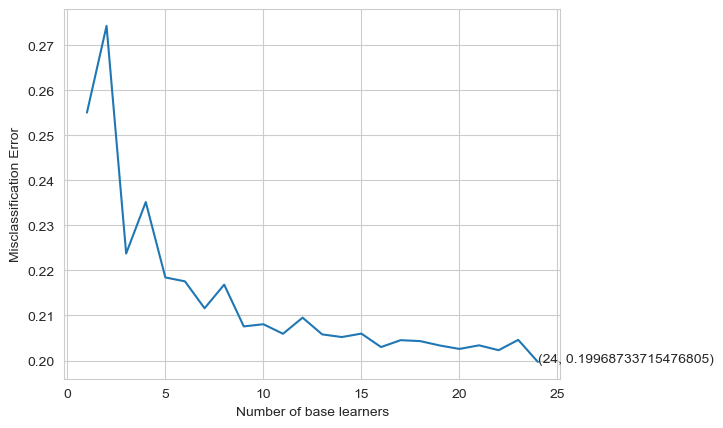

In [66]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                              #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                             #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                                        #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [67]:
# Training the best model and calculating error on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
print(f"Optimal Learners: {optimal_learners}")
print(f"Accuracy: {clf.score(X_test, y_test)}")

Optimal Learners: 24
Accuracy: 0.7933857501823782


It seems that adding the two features "quarter" and "retweets" didn't improve anything. Accuracy with 23 learners was about 79.6%.

In [68]:
# saving result for confussion matrix
result = clf.predict(X_test)

          Negative  Positive
Negative      1353      1738
Positive       811      8435
0.7933857501823782


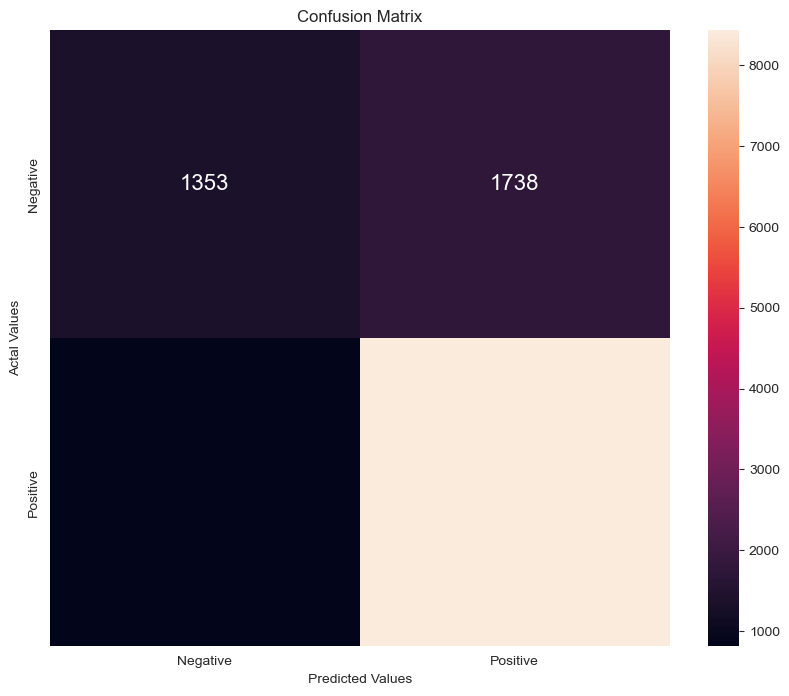

In [69]:
conf_mat = confusion_matrix(y_test, result)

conf_mat = pd.DataFrame(conf_mat,
                     index = ['Negative', 'Positive'],
                     columns = ['Negative', 'Positive'])

print(conf_mat)

print(metrics.f1_score(y_test, result,average='micro'))

#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True,fmt='g', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

The f1 score was about 79.6%. This value is identical to model 2. One thing thing interesting to note about this model is that it actually had slightly more true positives than model 2. In saying that, the model had slightly less true negatives.

## Model 4: Random Forest, Bag of Words, More features

In this model I uppped the number of features in the text column "content"

In [70]:
""" Using 1,500 features """

NUM_FEATURES = 1_500

bow_vec = CountVectorizer(max_features=NUM_FEATURES)

data_features = bow_vec.fit_transform(dataOne['content'])   

In [71]:
data_features.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [72]:
""" Testing and Train split. """

X_train, X_test, y_train, y_test = train_test_split(data_features, target, # inputs
                                                    test_size=0.2, # train size will compliment 
                                                    random_state=7
                                                   )

In [73]:
""" Initial Random Forest Model. """
rf_model = RandomForestClassifier(n_estimators=10, n_jobs=4) # calling model
rf_model.fit(X_train, y_train) # fit model on data

rf_crossVal = (np.mean(cross_val_score(rf_model, X, target, cv=10))) # cross validation metric

print(f"Accuracy: {rf_model.score(X_test, y_test):.5}") # train vs test
print(f"Cross Validation Score [10 folds]: {rf_crossVal:.5}")

Accuracy: 0.85264
Cross Validation Score [10 folds]: 0.76239


Initial accuracy greatly improved. When looking at the more robust metric Cross Validation Score, we see that the model is actually not as good as the Accuracy would indicate. Still, this model has the highest Cross Validation Score out of all models. 

In [74]:
# K - Fold Cross Validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

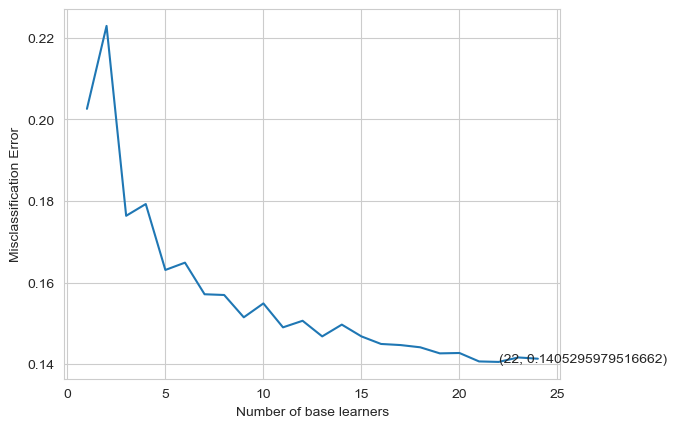

In [75]:
""" Finding Optimal Number of Learners. """

# plotting the error as k increases
error = [1 - x for x in cv_scores]                                              #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                             #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                                        #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [76]:
# Training the best model and calculating error on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
print(f"Optimal Learners: {optimal_learners}")
print(f"Accuracy: {clf.score(X_test, y_test)}")

Optimal Learners: 22
Accuracy: 0.8628571428571429


The accuracy was much better than the other models at 86.3

In [77]:
# saving result for confussion matrix
result = clf.predict(X_test)

          Negative  Positive
Negative      1408       602
Positive       526      5689
0.8628571428571429


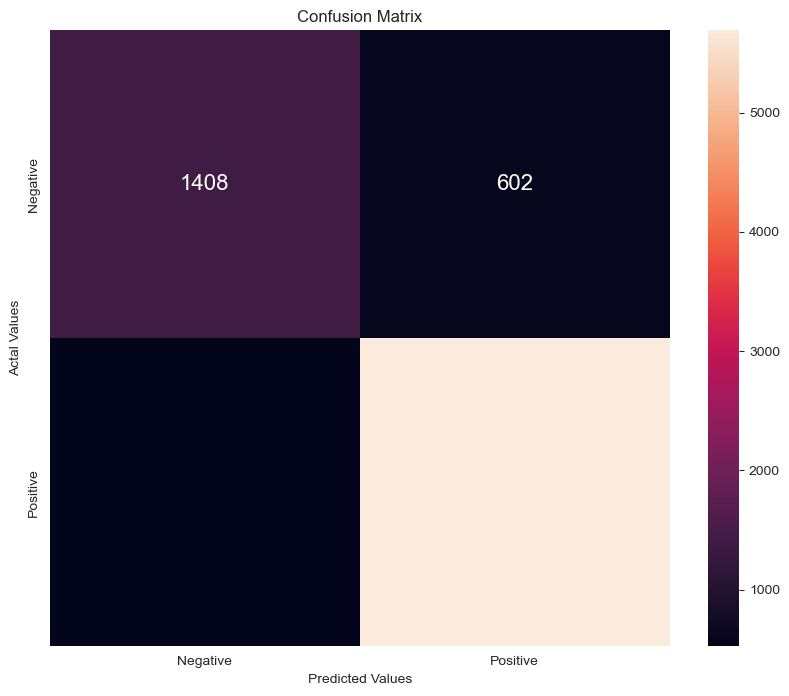

In [78]:
conf_mat = confusion_matrix(y_test, result)

conf_mat = pd.DataFrame(conf_mat,
                     index = ['Negative', 'Positive'],
                     columns = ['Negative', 'Positive'])

print(conf_mat)

print(metrics.f1_score(y_test, result,average='micro'))

#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True,fmt='g', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

Best true positive prediction and true negative prediction compared to other models. F1 score of 86.2% also the highest.

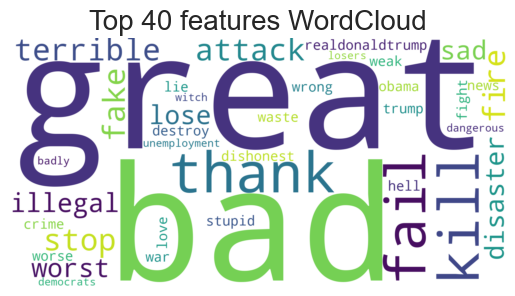

In [79]:
""" Wordcloud of top 40 text features. """

all_features = bow_vec.get_feature_names_out()             #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=' '

myWc2 = wordcloud.WordCloud(background_color="white",colormap='viridis',width=2000,
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(myWc2, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

Interestingly, it looks like great and bad are even more important words when more features (in this case words) were added. 

# Evaluation

### Summary 

| Metric                          | Model 1    | Model 2    | Model 3    | Model 4    |
|---------------------------------|------------|------------|------------|------------|
| Initial Cross Validation Score  | 75.2%      | 75.3%      | 76.4%      | 76.2%      |
| F1 Score (Optimal Learners)     | 79.3%      | 79.5%      | 79.3%      | 86.3%      |



In the model building portion of this notebook, four models in total were built. Two of the models built used the “Bag of Words” method to make the tokenized text numeric. The other two models used “Term Frequency-Inverse Document Frequency.” Before these methods were used, stop word removal, lemmatization, and stemming, was performed on the text data (as well as various other context specific methods).

All the models were built using Random Forest (RF) Classification. F1, Accuracy, and cross fold validation were the main metrics used when evaluating the models.  

In the first model, the inputs “content,” “retweets,” and “quarter,” were used. These inputs when used in a RF classification model scored an f1 score of about 79.3%. In the model’s initial cross validation score it scored 75.2%. This model was better at accurately classifying positive sentiment when compared to negative. At the models optimized number of learners, the accuracy reached a score of 79.3%. 

The second model used only the tweet text of the column “content” and to vectorize the text, it used the “Term Frequency-Inverse Document Frequency” method. This RF classification model had an initial cross validation score of approximately 75.3%. At this model’s optimal number of learners, the accuracy score reached 79.5%. This models f1 score was about 79.5%. In all metrics, this model did a hair worse than model two. 

Model three used the same text vectorization method as model two. This model added the inputs that model one also had, “retweets,” and “quarter.” In this RF classification model, the initial cross validation score was 76.4%. At this model’s optimal number of learners, the accuracy reached 79.3%. This models f1 score was 79.3%. This model was almost the exact same as the model one. The differences were negligible at best. 

Model four was the best model of the bunch. This model ditched the unnecessary input columns “retweets” and “date” (learned this from model 2 to 3 metric comparisons). This model increased the number of features in the text column “content” from 200 to 1,500. The initial cross validation score was about 76.2%. What’s interesting here is that the accuracy was around 85%. This shows the need to use cross validation as the training data could be overfit. Anyways, at the model’s optimal number of learners the accuracy was 86.3%. The f1 score was 86.3% with a great improvement on true positive and negative prediction ratios when compared to models 1 through 3. 
Metric	Model 1	Model 2	Model 3	Model 4




### For the Future 

- To speed up k-fold cross validation to find optimal number of learners, start with 5 instead of 1. 
- The models accuracy could be improved if the features in text column, "content" were increased.
- In the future, to compare the models, using TPR and FPR may be more concise when discussing f1 scores. 
- It would be intersting to see how effective a Logistic Regression model would be.
- Intersting to see effectiveness of removing "realdonaldtrump" from the tokenized text would be for model accuracy.
- Store model metrics in variables so there is not so much back and forth between writing and scrolling through models.